In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

import Tree
import Agent
np.random.seed(1)


In [ ]:
from tqdm.auto import tqdm

In [1]:
import maze_generator

  0%|          | 0/50 [00:00<?, ?it/s]

test pass 46/50


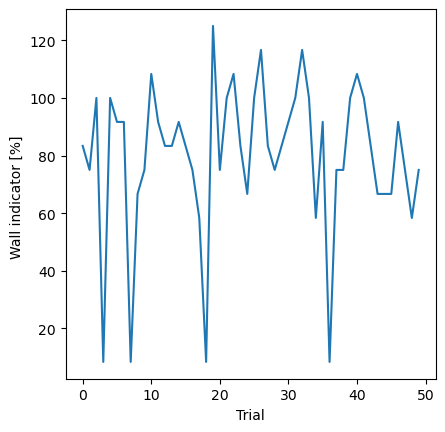

In [2]:
maze_generator.test_if_it_work()

In [ ]:
maze_generator.generate_a_maze( 10, N_episodes=500, exploration_decreasing_decay=0.01, seed=100 )

In [ ]:
N_grid = 4
tree = Tree.Cell_Tree( N_grid )
tree.visu()
###3000 0.001
agent = Agent.Agent(tree, N_episodes=500, exploration_decreasing_decay=0.01)

In [ ]:
#tree.build_WALL(7)

fig, ax = plt.subplots()
nep = 500
dec = -0.01
plt.plot( np.arange(nep), np.exp( dec* np.arange(nep) ) )

In [ ]:
agent.train(from_random=False )


In [ ]:
fig, ax = plt.subplots()

ax.imshow( (agent.Q_table) )


In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( agent.N_episodes ), agent.total_rewards_episode )

kernel = 100
moy_roulante = np.convolve( agent.total_rewards_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,agent.N_episodes  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [ ]:
np.argmax( agent.Q_table, 1 )

In [ ]:
agent.generate( from_random=False )
print( tree.check() )
print( tree.Wall_state.sum()*2 / tree.N_Wall *100 )
tree.visu()

In [ ]:
fig, ax = plt.subplots()

ax.plot( np.arange( agent.N_episodes ), agent.total_QV_episode, label='at all epochs' )

kernel = 20
moy_roulante = np.convolve( agent.total_QV_episode , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1,agent.N_episodes  ), moy_roulante, label='avg over 20 epochs' )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

ax.legend()
ax.set_xlabel( 'epochs' )
ax.set_ylabel( r'$\rm{ \sum \vert Qvalues \vert }$' )

In [ ]:
fig, ax = plt.subplots()

x = np.arange( agent.N_episodes-1 )
y = np.abs( np.diff( agent.total_QV_episode ) ) 

ax.plot( x, y )

kernel = 20
moy_roulante = np.convolve( y , np.ones(kernel), 'valid') / kernel
ax.plot( np.arange( kernel-1, y.shape[0]  ), moy_roulante )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

In [ ]:
N_grid = 4

N_trial = 50
N_Wall_trials = np.zeros(N_trial)
N_checked = np.zeros(N_trial).astype(bool)

for i in np.arange(N_trial):
    
    tree = Tree.Cell_Tree( N_grid )
    agent = Agent.Agent(tree, N_episodes=500, exploration_decreasing_decay=0.01)
    agent.train(from_random=False, verbose=False)

    agent.generate( from_random=False )
    N_Wall_trials[i] = tree.Wall_state.sum()
    N_checked[i] = tree.check()


In [ ]:
N_checked.sum()

In [ ]:
N_Wall_pc = N_Wall_trials * 2 * 100 / tree.N_Wall
fig, ax = plt.subplots()
x = np.arange(N_trial)
ax.plot( x, N_Wall_pc )

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect( (x1-x0)/(y1-y0) )

ax.set_xlabel( 'Trial' )
ax.set_ylabel( f'Wall indicator [%] ' )